<a href="https://colab.research.google.com/github/roman-mikhaylov/repo_sinergiya/blob/main/ML_5_20_Mikhaylov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

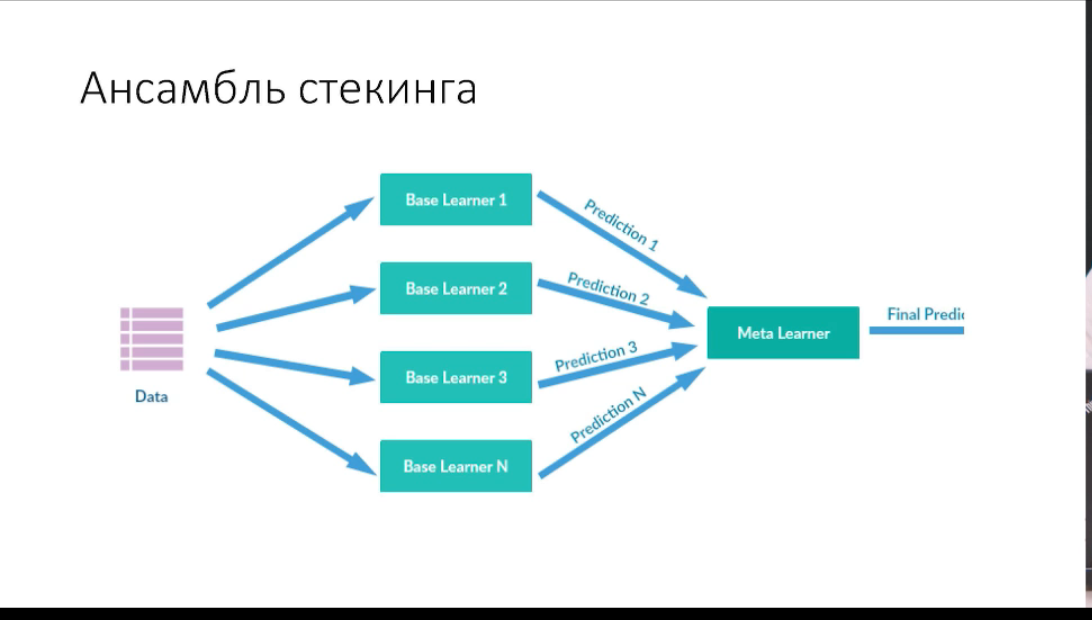

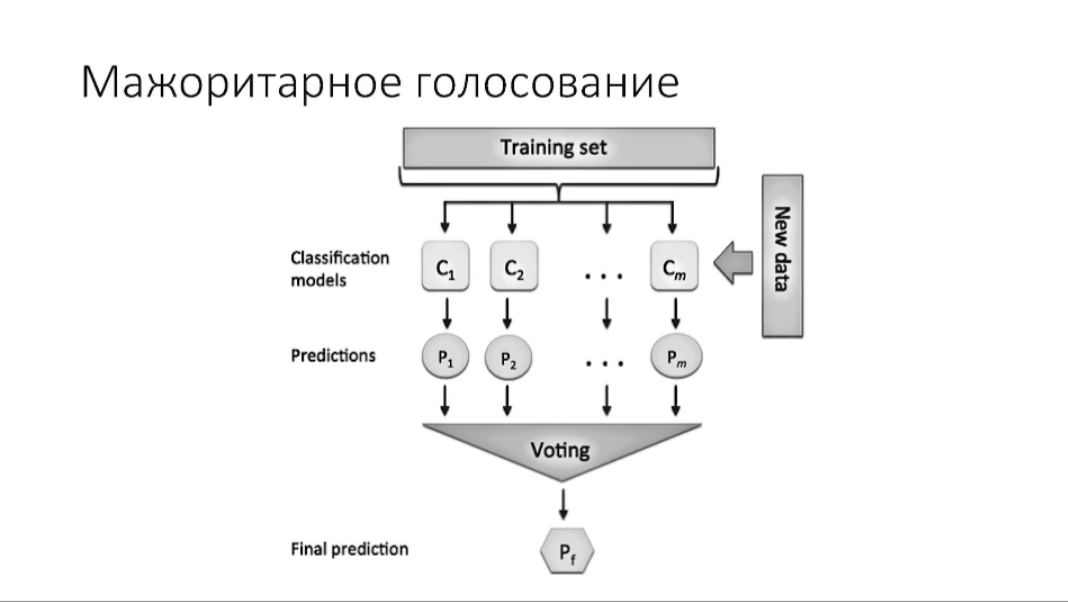

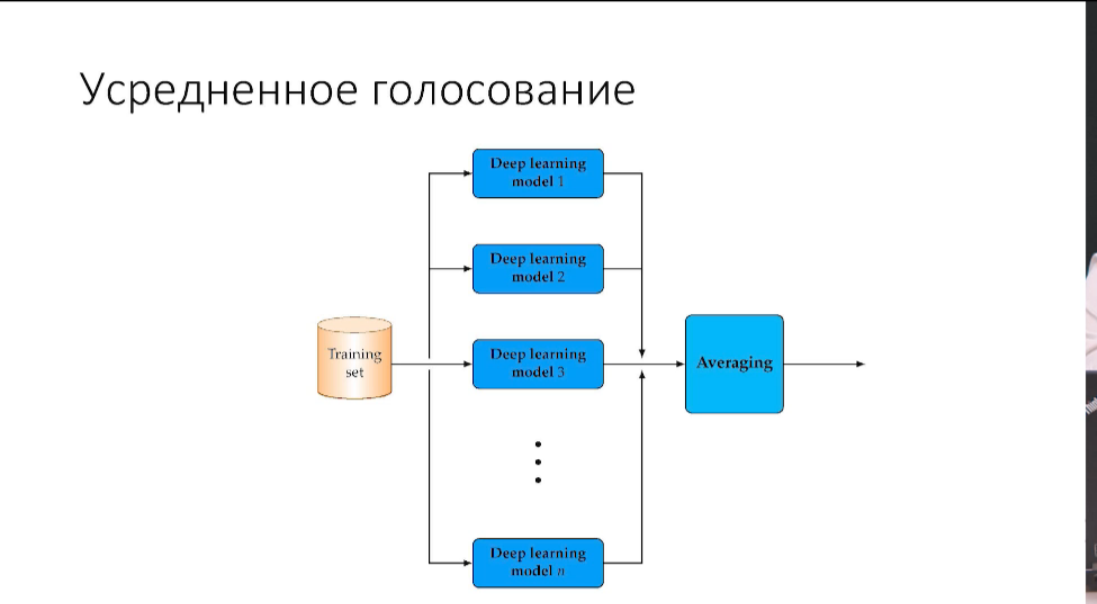

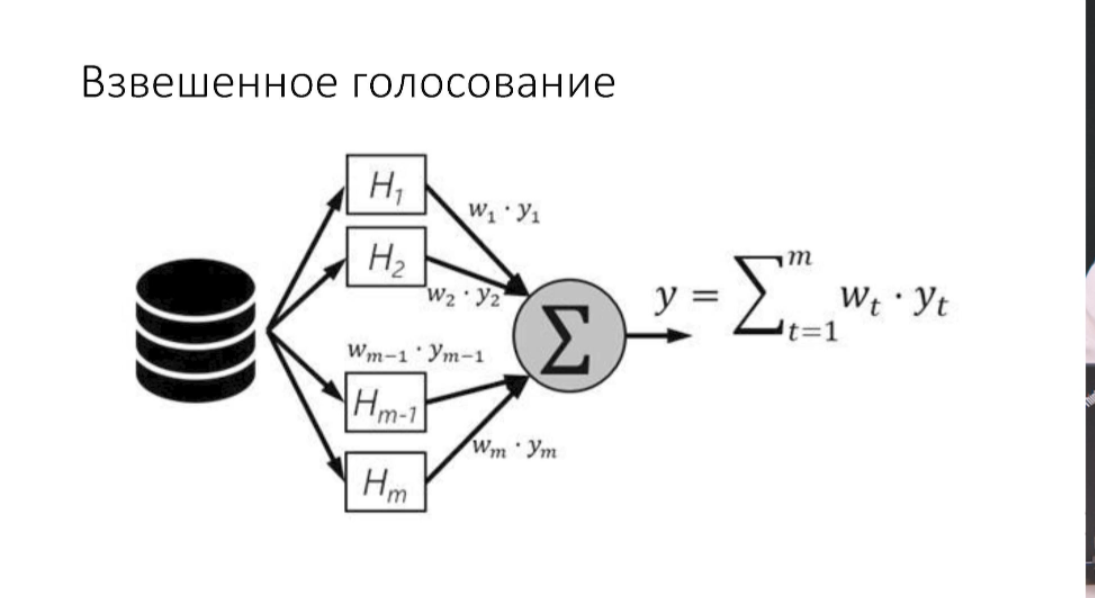

Практикум

In [2]:
!pip install optuna

In [3]:
import numpy as np
import pandas as pd
import sklearn

import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
#from scipy.stats import uniform
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import  train_test_split

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy_2.csv')

print(data.head())

             timestamp  meter_reading  air_temperature  cloud_coverage  \
0  2016-01-30 08:00:00        43.6839              8.3             0.0   
1  2016-01-31 05:00:00        37.5408             12.8             0.0   
2  2016-01-31 17:00:00        52.5571             20.6             0.0   
3  2016-04-08 14:00:00        59.3827             21.7             2.0   
4  2016-05-01 19:00:00       448.0000             31.1             0.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_speed  \
0              6.1                0.0              1019.0         2.1   
1             10.0                0.0              1021.9         0.0   
2             11.7                0.0              1020.9         1.5   
3             14.4                0.0              1015.1         3.1   
4             17.2                0.0              1016.1         4.1   

   air_temperature1  wind_direction_sin  wind_direction_cos  hour  
0              -2.3           -0.642788         

подбор параметров

последовательно переберемвсе линейные, квадратичные и кубические параметры из исходных данных, чтобы найти наилучшую комбинацию, используя BIC (Байесовый критерий)

In [5]:
def calculate_bic(y, y_pred, power):
  return len(y)*np.log(len(y)*mean_squared_log_error(y, y_pred)**2) + power*np.log(len(y))

In [6]:
columns = list(data.columns)
columns.remove("timestamp")
columns.remove("meter_reading")
columns.remove("hour")

линейные значения

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           5411 non-null   object 
 1   meter_reading       5411 non-null   float64
 2   air_temperature     5411 non-null   float64
 3   cloud_coverage      5411 non-null   float64
 4   dew_temperature     5411 non-null   float64
 5   precip_depth_1_hr   5411 non-null   float64
 6   sea_level_pressure  5383 non-null   float64
 7   wind_speed          5411 non-null   float64
 8   air_temperature1    5411 non-null   float64
 9   wind_direction_sin  5236 non-null   float64
 10  wind_direction_cos  5236 non-null   float64
 11  hour                5411 non-null   int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 507.4+ KB


In [8]:
data['sea_level_pressure'] = data['sea_level_pressure'].interpolate()
data['wind_direction_sin'] = data['wind_direction_sin'].interpolate()
data['wind_direction_cos'] = data['wind_direction_cos'].interpolate()

In [9]:
best_columns = []
current_columns = []
power = 0
best_power = 0
bic_best = 1000000
for column in columns:
  current_columns.append(column)
  power += 1
  y = data['meter_reading']
  x = MinMaxScaler().fit_transform(data[current_columns])
  bic = calculate_bic(y, LinearRegression().fit(x, y).predict(x), power)
  if bic < bic_best:
    best_columns.append(column)
    best_power += 1
    bic_best = bic
  else:
    power -= 1
    current_columns.remove(column)
print(best_columns)

['air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'air_temperature1']


квадратичные значения

In [10]:
for column in columns:
  data[column +'_2'] = np.multiply(data[column], data[column])

In [11]:
data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature1,wind_direction_sin,...,hour,air_temperature_2,cloud_coverage_2,dew_temperature_2,precip_depth_1_hr_2,sea_level_pressure_2,wind_speed_2,air_temperature1_2,wind_direction_sin_2,wind_direction_cos_2
0,2016-01-30 08:00:00,43.6839,8.3,0.0,6.1,0.0,1019.0,2.1,-2.3,-0.642788,...,8,68.89,0.0,37.21,0.0,1038361.00,4.41,5.29,0.413176,0.586824
1,2016-01-31 05:00:00,37.5408,12.8,0.0,10.0,0.0,1021.9,0.0,-1.1,0.000000,...,5,163.84,0.0,100.00,0.0,1044279.61,0.00,1.21,0.000000,1.000000
2,2016-01-31 17:00:00,52.5571,20.6,0.0,11.7,0.0,1020.9,1.5,1.7,0.939693,...,17,424.36,0.0,136.89,0.0,1042236.81,2.25,2.89,0.883022,0.116978
3,2016-04-08 14:00:00,59.3827,21.7,2.0,14.4,0.0,1015.1,3.1,2.8,-0.939693,...,14,470.89,4.0,207.36,0.0,1030428.01,9.61,7.84,0.883022,0.116978
4,2016-05-01 19:00:00,448.0000,31.1,0.0,17.2,0.0,1016.1,4.1,1.1,0.984808,...,19,967.21,0.0,295.84,0.0,1032459.21,16.81,1.21,0.969846,0.030154


In [12]:
for column in columns:
  r = column + "_2"
  current_columns.append(r)
  power += 1
  y = data['meter_reading']
  x = MinMaxScaler().fit_transform(data[current_columns])
  bic = calculate_bic(y, LinearRegression().fit(x, y).predict(x), power)
  if bic < bic_best:
    best_columns.append(r)
    best_power += 1
    bic_best = bic
  else:
    power -= 1
    current_columns.remove(r)
print(best_columns)

['air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'air_temperature1', 'air_temperature_2', 'cloud_coverage_2', 'dew_temperature_2', 'sea_level_pressure_2']


Кубические значения

In [13]:
for column in columns:
  data[column +'_3'] = np.multiply(data[column + '_2'], data[column])

In [14]:
for column in columns:
  r = column + "_3"
  current_columns.append(r)
  power += 1
  y = data['meter_reading']
  x = MinMaxScaler().fit_transform(data[current_columns])
  bic = calculate_bic(y, LinearRegression().fit(x, y).predict(x), power)
  if bic < bic_best:
    best_columns.append(r)
    best_power += 1
    bic_best = bic
  else:
    power -= 1
    current_columns.remove(r)
print(best_columns)

['air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'air_temperature1', 'air_temperature_2', 'cloud_coverage_2', 'dew_temperature_2', 'sea_level_pressure_2', 'air_temperature_3', 'cloud_coverage_3', 'sea_level_pressure_3', 'wind_speed_3', 'wind_direction_cos_3']


Разделение данных на обучающую и проверочние

In [15]:
# норамлизация данных
data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data[best_columns]))

In [16]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5411 non-null   float64
 1   1       5411 non-null   float64
 2   2       5411 non-null   float64
 3   3       5411 non-null   float64
 4   4       5411 non-null   float64
 5   5       5411 non-null   float64
 6   6       5411 non-null   float64
 7   7       5411 non-null   float64
 8   8       5411 non-null   float64
 9   9       5411 non-null   float64
 10  10      5411 non-null   float64
 11  11      5411 non-null   float64
 12  12      5411 non-null   float64
 13  13      5411 non-null   float64
 14  14      5411 non-null   float64
dtypes: float64(15)
memory usage: 634.2 KB


In [17]:
#разделеение данный на обучающие и проверочные
train, test, y_train, y_test = train_test_split(data_norm, data["meter_reading"], test_size=0.2)

Модели регрессии

линеная и изотоническая
проверяем на них

In [18]:
# функция ошибки RMSLE
def rmsle_err(y, y_pred):
  return ((np.log(1 + y) - np.log(1 + y_pred))**2).mean()**0.5


In [19]:
y = data['meter_reading']
model1 = LinearRegression().fit(train, y_train)
print('RMSLE: {0:.5}'. format(rmsle_err(y_train, model1.predict(train))))

RMSLE: 0.19876


In [20]:
y = data['meter_reading']
model1 = LinearRegression().fit(train, y_train)
print('RMSLE: {0:.5}'. format(rmsle_err(y_train, model1.predict(train))))

RMSLE: 0.19876


In [21]:
model2 = IsotonicRegression(out_of_bounds='nan').fit(train[0], y_train)
print('RMSLE: {0:.5}'.format(rmsle_err(y_train, model2.predict(train[0]))))

RMSLE: 0.22029


ElasticNet

выберем лучшие гиперпараметры

In [22]:
from sklearn.linear_model import ElasticNet

In [23]:
def objective_elastic(trial):
  alpha = trial.suggest_float('alpha', 1e-8, 1, log=True)
  l1_ratio = trial.suggest_float('l1_ratio', 1e-3, 1, log=True)
  regressor_obj = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
  regressor_obj.fit(x,y)
  y_pred = regressor_obj.predict(x)
  return mean_squared_log_error(y,y_pred)

In [ ]:
study_elastic = optuna.create_study()
study_elastic.optimize(objective_elastic, n_trials=100)

In [25]:
model3 = ElasticNet(alpha=study_elastic.best_params['alpha'],
                    l1_ratio=study_elastic.best_params['l1_ratio'],
                    max_iter=10000, tol=0.01).fit(train,y_train)
print ('RMSLE: {0:.5}'. format(rmsle_err(y_train, model3.predict(train))))

RMSLE: 0.20155


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e+06, tolerance: 1.058e+05
  model = cd_fast.enet_coordinate_descent(


In [26]:
print(study_elastic.best_params)

{'alpha': 1.55680063936155e-08, 'l1_ratio': 0.9882779740099943}


Обьединение моделей

используя оптуна для определние оптимального коффициен7та

In [27]:
def objective_el(trial):
  alpha = trial.suggest_float('alpha', 1e-10, 1, log=True)
  beta = trial.suggest_float('beta', 1e-10, 1 - alpha, log=True)
  y_pred = (alpha*model1.predict(test) + beta*model2.predict(test[0]) + (1-alpha-beta)*model3.predict(test))
  return mean_squared_log_error(y_test, y_pred)

In [ ]:
study_el = optuna.create_study()
study_el.optimize(objective_el, n_trials=100)

In [29]:
print(study_el.best_params)

{'alpha': 0.9966635816760373, 'beta': 1.0891396942751553e-05}


In [30]:
y_pred1 = model1.predict(data_norm)
y_pred2 = model2.predict(data_norm[0])
y_pred3 = model3.predict(data_norm)
y_pred = (study_el.best_params['alpha'])*y_pred1 + (study_el.best_params['beta'])*y_pred2 + (1-study_el.best_params['alpha']- (study_el.best_params['beta'])*y_pred3)
print ('RMSLE линейной регрессии: {0:.5}'. format(rmsle_err(y, y_pred1)))
print ('RMSLE изотонической регрессии: {0:.5}'. format(rmsle_err(y, y_pred2)))
print ('RMSLE EllasticNet: {0:.5}'. format(rmsle_err(y, y_pred3)))
print ('RMSLE ансамбля: {0:.5}'. format(rmsle_err(y, y_pred)))

RMSLE линейной регрессии: 0.19481
RMSLE изотонической регрессии: 0.21628
RMSLE EllasticNet: 0.19763
RMSLE ансамбля: 0.19454


задание спикера

1.построить 24 ансамбля регрессий по часам вычислить общую RMSLE

In [31]:
ensamble = []
#y = data['meter_reading']

for h in range(24):
  data1 =  data.loc[data['hour'] == h]
  # норамлизация данных
  data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data1[best_columns]))

  y = data1['meter_reading']

  #model1 = LinearRegression().fit(train, y_train)
  #model2 = IsotonicRegression(out_of_bounds='clip').fit(train[0], y_train)
  #model3 = ElasticNet(alpha=study_elastic.best_params['alpha'],
  #                  l1_ratio=study_elastic.best_params['l1_ratio'], max_iter=100000).fit(train,y_train)

  y_pred1 = model1.predict(data_norm)
  y_pred2 = model2.predict(data_norm[0])
  y_pred3 = model3.predict(data_norm)
  y_pred = (study_el.best_params['alpha'])*y_pred1 + (study_el.best_params['beta'])*y_pred2 + (1-study_el.best_params['alpha']- (study_el.best_params['beta'])*y_pred3)

  ensamble.append(y_pred)
  #print("RMSLE по часу: ", h, rmsle_err(y, y_pred))
  print(len(ensamble))
print('RMSLE ансамбля: {0:.5}'. format(rmsle_err(y, y_pred)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
RMSLE ансамбля: 0.20165


2. Постройте ансамбль изотонических регрессий по лучшим параметрам и найдите его RMSLE

In [65]:
ensamble = []

for i in best_columns:#['air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'air_temperature1']:

  x = np.array(data[i]).reshape(-1,1)
  y = data['meter_reading']
  model_is = IsotonicRegression().fit(x, y)

  ensamble.append(model_is)
  print(len(ensamble))

  print(i,'RMSLE: {0:.5}'.format(rmsle_err(y, model_is.predict(x))))
print("-----------------------------")
print('RMSLE ансамбля: {0:.5}'.format(rmsle_err(y, model_is.predict(x).mean())))

1
air_temperature RMSLE: 0.21622
2
dew_temperature RMSLE: 0.2033
3
precip_depth_1_hr RMSLE: 0.25248
4
sea_level_pressure RMSLE: 0.25308
5
wind_speed RMSLE: 0.25299
6
air_temperature1 RMSLE: 0.25272
7
air_temperature_2 RMSLE: 0.21622
8
cloud_coverage_2 RMSLE: 0.25253
9
dew_temperature_2 RMSLE: 0.2033
10
sea_level_pressure_2 RMSLE: 0.25308
11
air_temperature_3 RMSLE: 0.21622
12
cloud_coverage_3 RMSLE: 0.25253
13
sea_level_pressure_3 RMSLE: 0.25308
14
wind_speed_3 RMSLE: 0.25299
15
wind_direction_cos_3 RMSLE: 0.25308
-----------------------------
RMSLE ансамбля: 0.25308
